 ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ АВТОНОМНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ «НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ ИТМО»
 
 Факультет ПИиКТ

 Дисциплина:
Нейроинтерфейсы информационных систем

---


## Лабораторная работа 1: 
## "Исследование сигналов человека при помощи набора Bitronics Neurolab"

---
Работу выполнили:

Пушкарев Даниил Александрович

Курдюмов Дмитрий Александрович

Мороз Сергей Владимирович

Ян Цзяфэн

---
### Цели работы:
1.   Измерить показания сигналов ЭЭГ (на затылочной и лобной долях мозга), ЭКГ и ЭМГ при помощи набора Bitronics Neurolab. 
2.   Выполнить предварительную обработку сигнала ЭЭГ и найти 𝛼- и 𝛽-волны в сигнале при помощи Фурье преобразований.
3.   Выполнить предварительную обработку сигнала ЭКГ, определить пульс и построить пульсограмму.
4.   По сигналу ЭМГ определить моменты сокращения мыщцы.


### 1.  Обработка сигналов ЭЭГ
Вначале необходимо выполнить нормализацию и ресемплирование сигнала для последующей обработки. После этого для нахождения 𝛼- и 𝛽-волн в сигнале необходимо использовать алгоритм STFT(Short-Time-Fourier-Transform), который выполняет БПФ для определнного участка(окна) сигнала, что помогает детектировать волны на временном интервале, а не факт их наличия в спектре сигнала. 

Для детектирования слабых волн, которые могут перекрываться более высокочастотными составляющими, во время работы алгоритма STFT будут использоваться различные оконные функции, обеспечивающие сглаживание амплитуды сигнала на каждом из участков.


Импорт функций для обработки данных

In [ ]:
# importing libraries

import pandas as pd
import numpy as np
from scipy.signal import resample, stft, find_peaks
from scipy.fft import fftfreq
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Выполним  чтение данных ЭЭГ с разных каналов записи. Создадим для этого функцию, обеспечивающую загрузку данных и исправление временного ряда сигнала (иногда встречаются два подряд идущих измерения уровня сигнала для одного и того же момента времени). В конце выполним ресемплирование сигнала, т.к. измерения проводились не в дискретные моменты времени.

Функция будет возвращать значение частоты сигнала, время записи в секундах и значения ресемплированного сигнала. Пользователь может вручную указать требуемое значение частоты

In [ ]:
def load_data(url, freq=None):
  data = pd.read_csv(url, header=None)
  data.drop_duplicates(subset=0, inplace=True)
  data[0] = data[0] - np.min(data[0])
  print('Record lasted {1} seconds and contains {0} samples'.format(len(data), data.iloc[-1,0]))
  if freq is None:
    F_s = int(len(data) / data.iloc[-1,0])
  else:
    F_s = freq
  t = int(np.floor(data.iloc[-1,0]))
  print('Frequency is {} Hz. Resample in {} Hz on the {} seconds recording'.format(len(data) / data.iloc[-1,0],
                                                                                   F_s, t))
  signal = resample(data[1], t*F_s)
  signal = StandardScaler().fit_transform(signal.reshape(-1,1))

  return F_s, t, signal


Выполним чтение первой ЭЭГ, которая регистрировала изменения сигнала на затылочной доле мозга и построим график первых 5 секунд записи

Record lasted 432.93183518 seconds and contains 105685 samples
Frequency is 244.1146421030908 Hz. Resample in 50 Hz on the 432 seconds recording
Record lasted 462.22468568999994 seconds and contains 112837 samples
Frequency is 244.1172085639674 Hz. Resample in 50 Hz on the 462 seconds recording


Text(0.5, 1.0, 'Лобная доля')

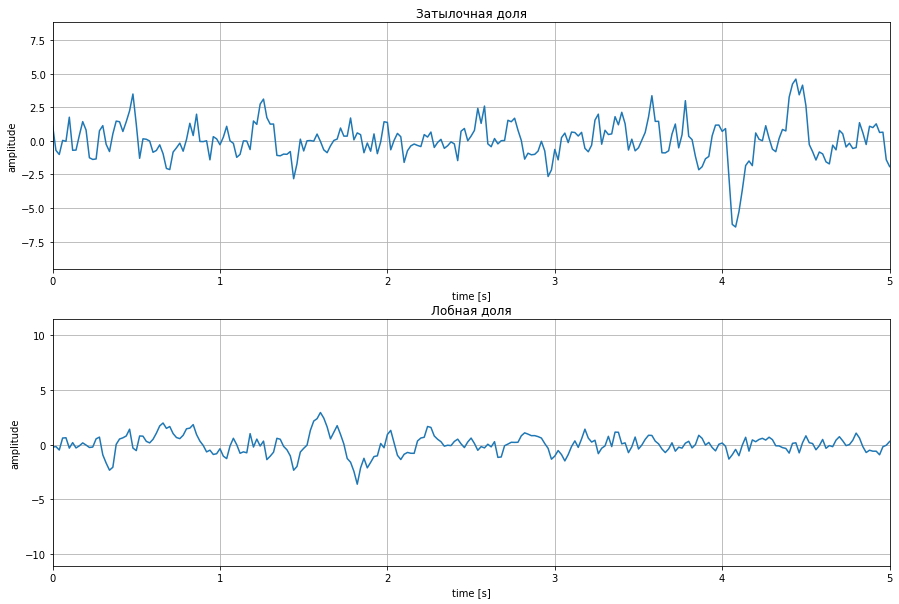

In [ ]:
F_s_1, t_1, signal_1 = load_data('https://raw.githubusercontent.com/DimaKurd/neurointerfaces/main/EEG_alpha.csv',50)
F_s_2, t_2, signal_2 = load_data('https://raw.githubusercontent.com/DimaKurd/neurointerfaces/main/EEG_betta.csv',50)

plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, t_1, t_1*F_s_1), signal_1)
plt.xlim(0, 5)
plt.xlabel('time [s]')
plt.ylabel('amplitude')
plt.title('Затылочная доля')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, t_2, t_2*F_s_2), signal_2)
plt.xlim(0, 5)
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('amplitude')
plt.title('Лобная доля')

Применим STFT на полученных данных и построим график распределения частот сигнала по времени сигнала. Будем использовать разную ширину окна, кратную частоте сигнала. В качестве оконной функции будем использовать функцию kaiser с параметром beta=10 и с перекрытием, равным половине ширины окна

Так же напишем функцию, выводящую 4 графика для разной ширины окна.

In [ ]:
def find_waves(F, t, signal):
  plt.figure(figsize=(20,5))
  for i in range(1,5):
    plt.subplot(1,4,i)
    f, t, Sxx = stft(signal.reshape(1,-1), F ,window=('kaiser', 10) ,nperseg=F*i)
    plt.pcolormesh(t, f, np.abs(Sxx.reshape(len(f), len(t))), shading='gouraud')
    plt.colorbar()
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('window width is {} samples'.format(F*i))
    plt.ylim(0,F//2)

    r = np.argmax(np.abs(Sxx))//len(t)
    c = np.argmax(np.abs(Sxx)) - r*len(t)
    # print(np.abs(Sxx.reshape(len(f), len(t)))[r,c])
    print('Peak is registered on the {} plot {:.2f} Hz {:.2f} s'.format(i, (r/len(f))*np.max(f), (c/len(t))*np.max(t)))

Построим графики для обоих сигналов

Сигнал на затылочной доле:

Peak is registered on the 1 plot 3.85 Hz 67.42 s
Peak is registered on the 2 plot 1.96 Hz 300.30 s
Peak is registered on the 3 plot 3.95 Hz 67.27 s
Peak is registered on the 4 plot 1.49 Hz 298.62 s


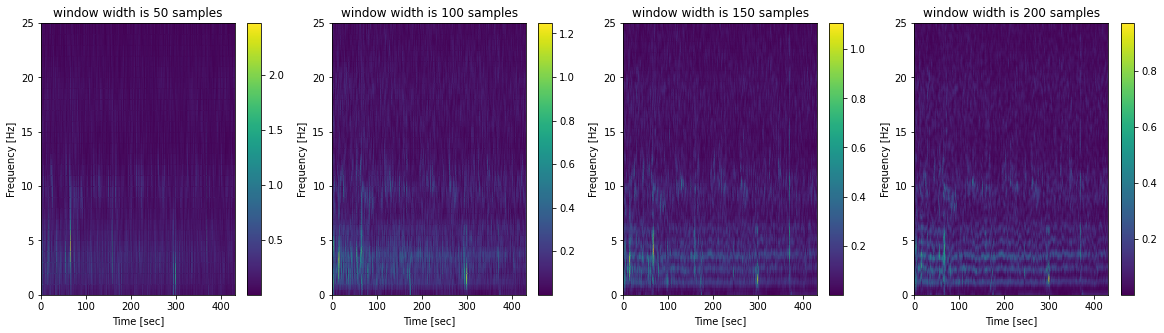

In [ ]:
find_waves(F_s_1, t_1, signal_1)

Сигнал на лобной доле:

Peak is registered on the 1 plot 1.92 Hz 232.75 s
Peak is registered on the 2 plot 1.96 Hz 232.50 s
Peak is registered on the 3 plot 2.63 Hz 427.61 s
Peak is registered on the 4 plot 2.48 Hz 428.15 s


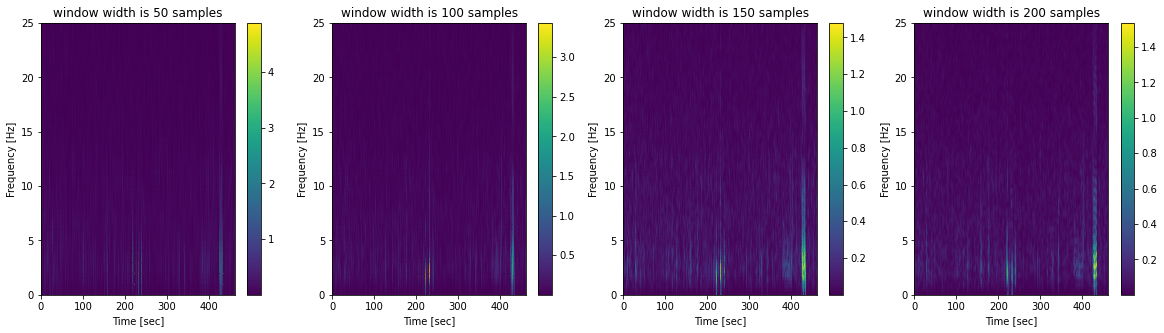

In [ ]:
find_waves(F_s_2, t_2, signal_2)

Для малого размера окна мы можем определить точный момент возникноения волны в сигнале, в то время как для большего размера окна мы можем проследить преобладающие частоты во всем сигнале.

В сигнале на затылочной доле мозга преобладают частоты 1-7 Гц, что является признаком существования θ-волн в сигнале. 

Для сигнала на лобной доле головного мозга наблюдаются всплески активности в этом же диапазоне.

Рассмотрим два интервала этих сигналов, где наблюдалась наибольшая активность. Для этого создадим функцию, выводящую график ЭЭГ, Фурье-преобразования и спектрограммы интервала сигнала

In [ ]:
def look_close(F_s, t, signal, s_t, f_t):
  # plotting pretty figure
  from scipy.fft import rfft, fftfreq, fftshift
  
  plt.figure(figsize=(12, 6))

  plt.subplot(1,2,1)
  plt.plot(np.linspace(0, t, t*F_s), signal)
  plt.title('EEG of {}-{} seconds'.format(s_t, f_t))
  plt.xlabel('Time [s]')
  plt.ylabel('Value')
  plt.xlim(s_t, f_t)
  plt.grid(True)

  plt.subplot(1, 2, 2)
  f, t, Sxx = stft(signal.reshape(1,-1), F_s, window=('kaiser', 10) ,nperseg=F_s)
  plt.pcolormesh(t,f, np.abs(Sxx.reshape(len(f), len(t))), shading='gouraud', cmap='binary')
  plt.colorbar()
  plt.title('Spectrogram of {}-{} seconds'.format(s_t, f_t))
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.ylim(0,20)
  plt.xlim(s_t, f_t)
  plt.grid(True)

Детальный вид интервала 67-68 с на затылочной доле

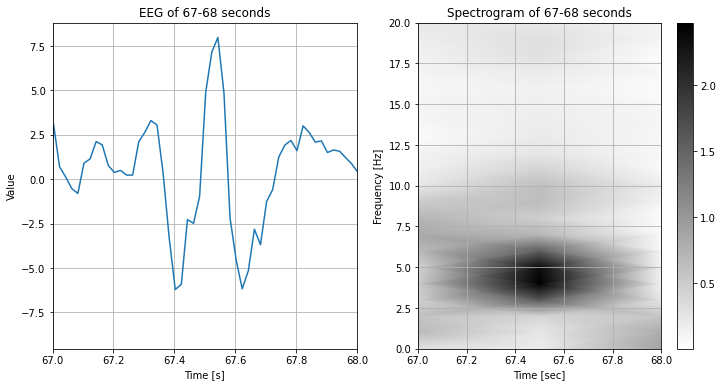

In [ ]:
look_close(F_s_1, t_1, signal_1, 67, 68)

Детальный вид интервала 232-233 с на лобной доле

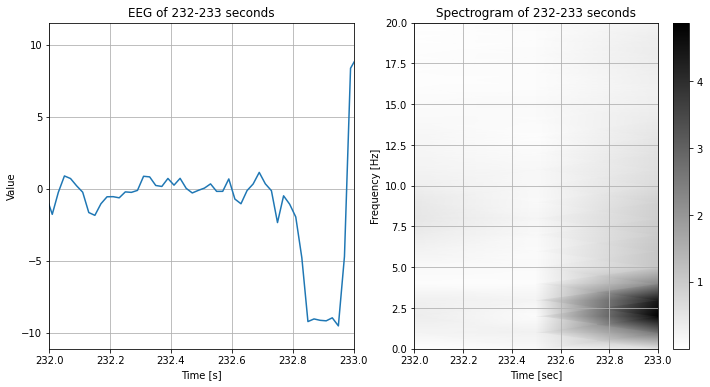

In [ ]:
look_close(F_s_2, t_2, signal_2, 232, 233)

Результаты исследований показывают, что ЭЭГ крайне нестабильна и находится в области низких частот, что соответствует θ-ритмам.

### Обработка ЭКГ сигналов
Загрузим данные и найдем пики сигнала, указывающие на удары сердца

Record lasted 41.30352790000006 seconds and contains 10084 samples
Frequency is 244.14379382832294 Hz. Resample in 8 Hz on the 41 seconds recording


Text(0, 0.5, 'amplitude')

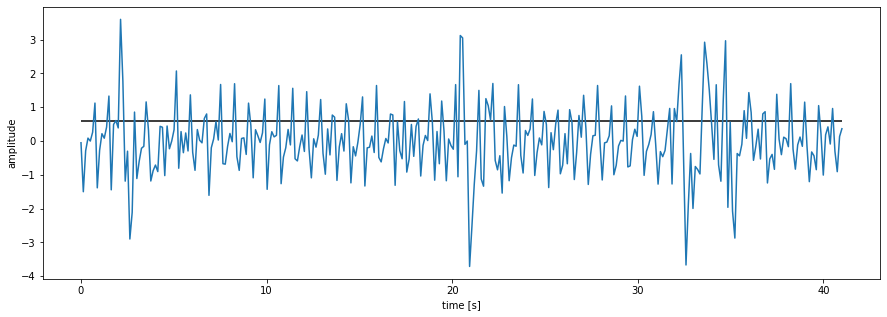

In [ ]:

F_k, t_k, signal_k = load_data('https://raw.githubusercontent.com/DimaKurd/neurointerfaces/main/EKG.csv', 8)

plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, t_k, t_k*F_k), signal_k)
# plt.xlim(40, 60)
plt.hlines(y=0.6, xmin=0, xmax = t_k, )
plt.xlabel('time [s]')
plt.ylabel('amplitude')

На графике выше представлено 20 секунд ЭКГ записи

Найдем пики сигнала и определим средний пульс

In [ ]:
peaks, _ = find_peaks(signal_k.reshape(signal_k.shape[0]), height=0.65, distance=F_k//3)
pulse = int(len(peaks)/(t_k/60))

print('Pulse is equal to {} bpm'.format(pulse))

Pulse is equal to 83 bpm


Построим пульсограмму сигнала. Для этого определим R-R интервалы по найденным пикам сигнала. Также выведем гистограмму - распределение R-R интервалов

Text(0.5, 1.0, 'Pulsogram')

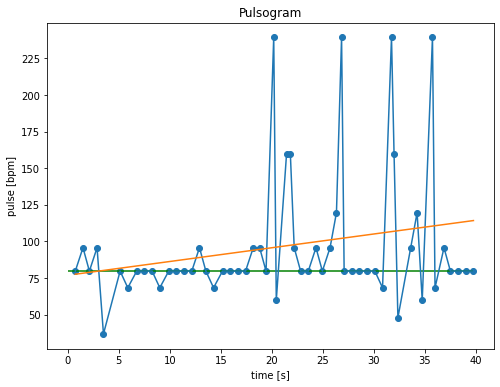

In [ ]:
pulsogram = pd.DataFrame({'time':np.linspace(0, t_k, t_k*F_k)[peaks]})
pulsogram['R-R'] = pulsogram['time'].shift(-1) - pulsogram['time']
pulsogram['pulse'] = 60/pulsogram['R-R']

from sklearn.linear_model import Lasso, LinearRegression
pulsogram.dropna(inplace=True)
y_pred = Lasso().fit(pulsogram['time'].values.reshape(-1,1), pulsogram['pulse']).predict(pulsogram['time'].values.reshape(-1,1))
pulsogram['mse'] = y_pred

plt.figure(figsize=(8,6))
plt.plot(pulsogram['time'], pulsogram['pulse'])
plt.plot(pulsogram['time'], pulsogram['mse'])
plt.scatter(pulsogram['time'], pulsogram['pulse'])
plt.hlines(np.median(pulsogram['pulse'].dropna().values), 0, np.max(pulsogram['time']), 'g')

plt.xlabel('time [s]')
plt.ylabel('pulse [bpm]')
plt.title('Pulsogram')

Text(0, 0.5, 'ratio')

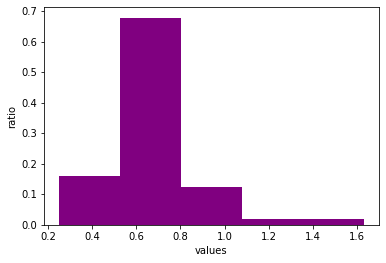

In [ ]:
plt.hist(pulsogram['R-R'], weights=np.ones(len(pulsogram))/len(pulsogram), color='purple', bins=5)
plt.xlabel('values')
plt.ylabel('ratio')

Зеленая линия показывает медианное значение пульса, вычисленное для сигнала. 

### EMG сигнал
Загрузим данные и визуализируем сигнал

Record lasted 43.47522739999998 seconds and contains 6728 samples
Frequency is 154.75479721125055 Hz. Resample in 154 Hz on the 43 seconds recording


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Myogram')

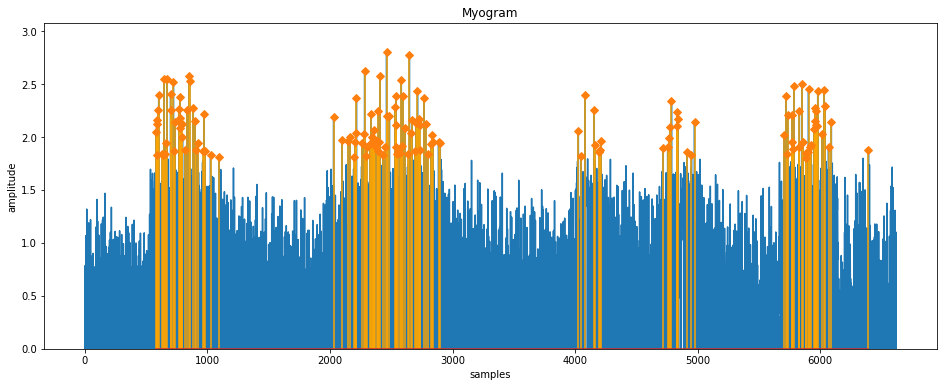

In [ ]:
F_m, t_m, signal_m = load_data('https://raw.githubusercontent.com/DimaKurd/neurointerfaces/main/EMG.csv')

peaks, _ = find_peaks(signal_m.reshape(signal_m.shape[0]), height=1.8)
color = np.zeros(len(signal_m), dtype=np.int8)
color[peaks] = 1

plt.figure(figsize=(16,6))
plt.plot(signal_m,)
plt.stem(peaks, signal_m[peaks], linefmt='orange', markerfmt='D')
plt.ylim(0,)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title('Myogram')

 Таким образом, на графике четко видны области, где мышца была напряжена (выделены желтым на графике)

В ходе работы были изучены базовые методы обработки биометрических сигналов человека, такие как: ЭЭГ, ЭКГ и ЭМГ.